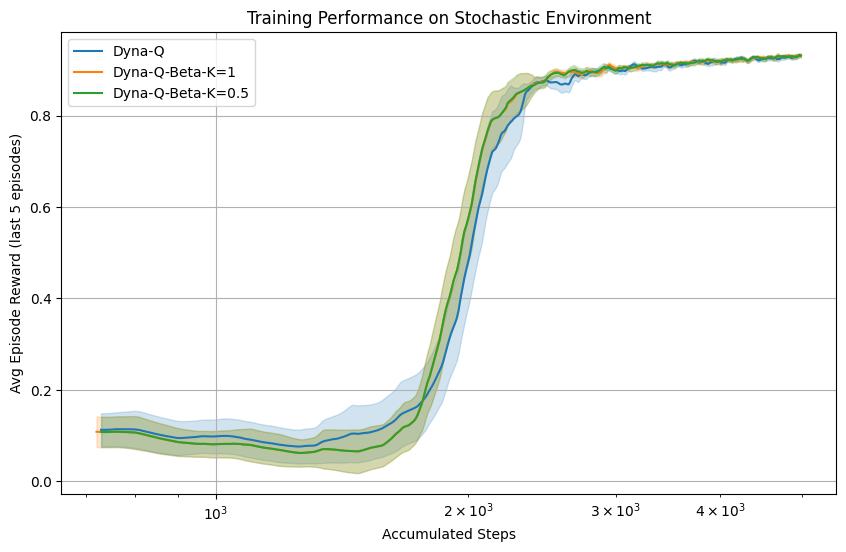

In [3]:
import pandas as pd
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
from trackio import SQLiteStorage

# ==== CONFIG ====
# Fill in trackio project names
PROJECTS = [
    ("DYNA-Q-BASE", "Dyna-Q"),
    ("DYNA-Q-BETA-K1", "Dyna-Q-Beta-K=1"),
    ("DYNA-Q-BETA-K05", "Dyna-Q-Beta-K=0.5"),

    #("DYNA-Q-BASE-STOCHASTIC", "Dyna-Q"),
    #("DYNA-Q-BETA-STOCHASTIC-K1", "Dyna-Q-Beta-K=1"),
    #("DYNA-Q-BETA-STOCHASTIC-K05", "Dyna-Q-Beta-K=0.5"),

    #("Q-BASE-STOCHASTIC", "Q"),
    #("Q-BETA-STOCHASTIC-K1", "Q-Beta-K=1"),
    #("Q-BETA-STOCHASTIC-K05", "Q-Beta-K=0.5"),

    #("Q-BASE", "Q"),
    #("Q-BETA-K1", "Q-Beta-K=1"),
    #("Q-BETA-K05", "Q-Beta-K=0.5"),
]

N = 5  # rolling average window
NUM_POINTS = 500  # resolution for interpolation
# ================

def load_project_data(project_name):
    """Load and expand the metrics table for a project."""
    path = SQLiteStorage.get_project_db_path(project=project_name)
    conn = sqlite3.connect(path)
    df = pd.read_sql_query('SELECT * FROM metrics', conn)
    conn.close()

    # Expand metrics JSON into columns
    metrics_df = df['metrics'].apply(json.loads).apply(pd.Series)
    df_expanded = pd.concat([df.drop(columns=['metrics']), metrics_df], axis=1)

    # Group runs
    dfs_by_run = {
        run: run_df.reset_index(drop=True)
        for run, run_df in df_expanded.groupby('run_name')
    }
    return dfs_by_run

def process_runs(dfs_by_run):
    """Process runs: remove trailing zero-reward row, rolling mean, accumulate steps."""
    processed = []
    for run, run_df in dfs_by_run.items():
        if run_df.iloc[-1]['episode_reward'] == 0:
            run_df = run_df.iloc[:-1]

        run_df = run_df.sort_values('step')
        run_df['accum_steps'] = run_df['episode_length'].cumsum()
        run_df['avg_reward'] = run_df['episode_reward'].rolling(window=N).mean()
        processed.append(run_df[['accum_steps', 'avg_reward']])
    return processed

def interpolate_runs(processed_runs):
    """Interpolate runs to a common step grid and compute mean + stderr."""
    max_steps = min(run['accum_steps'].max() for run in processed_runs)
    step_grid = np.linspace(0, max_steps, NUM_POINTS)

    interpolated = []
    for run_df in processed_runs:
        interp_values = np.interp(
            step_grid,
            run_df['accum_steps'],
            run_df['avg_reward']
        )
        interpolated.append(interp_values)

    interpolated = np.array(interpolated)
    mean_perf = interpolated.mean(axis=0)
    stderr_perf = interpolated.std(axis=0) / np.sqrt(interpolated.shape[0])
    return step_grid, mean_perf, stderr_perf

# ==== MAIN ====
plt.figure(figsize=(10, 6))

colors = plt.cm.tab10.colors  # up to 10 distinct colors

for i, (project, label) in enumerate(PROJECTS):
    dfs_by_run = load_project_data(project)
    processed_runs = process_runs(dfs_by_run)
    step_grid, mean_perf, stderr_perf = interpolate_runs(processed_runs)

    plt.plot(step_grid, mean_perf, color=colors[i % len(colors)], label=f"{label}")
    plt.fill_between(
        step_grid,
        mean_perf - 1.96 * stderr_perf,
        mean_perf + 1.96 * stderr_perf,
        color=colors[i % len(colors)],
        alpha=0.2
    )

plt.xlabel("Accumulated Steps")
plt.ylabel(f"Avg Episode Reward (last {N} episodes)")
plt.title("Training Performance on Stochastic Environment")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()


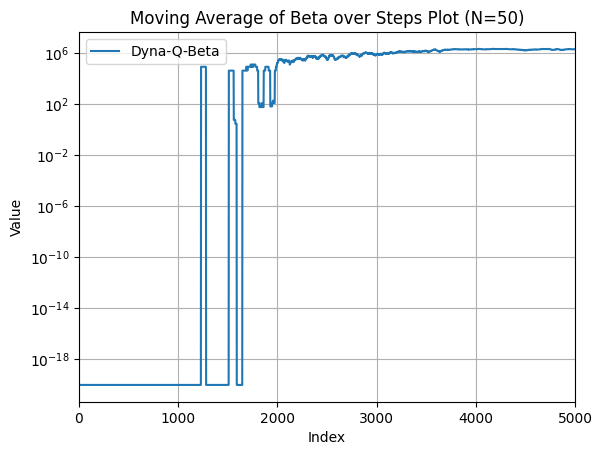

In [1]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    """
    Calculates the moving average of a list of data.
    """
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")
    
    averages = []
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        window = data[start_index : i + 1]
        averages.append(sum(window) / len(window))
    return averages

files = [
    #("data/beta_base.txt","Q-Beta")
    ("data/beta_dyna.txt", "Dyna-Q-Beta")
]

N = 50  # The number of datapoints to average over

for file, label in files:
    # Read list back from file
    loaded_data = []
    with open(file, "r") as f:
        for line in f:
            loaded_data.append(float(line.strip()))

    # Calculate the moving average
    averaged_data = moving_average(loaded_data, N)

    # Plot the averaged data
    plt.plot(averaged_data, label=f"{label}")

plt.title(f"Moving Average of Beta over Steps Plot (N={N})")
plt.xlabel("Index")
plt.ylabel("Value")
plt.xlim(left=0, right=5000)
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()